# Taller 1
****
Juan David Arias Guarín   

## Punto 1 - Eficiencia

Dada un conjunto de n imágenes (n de gran tamaño) se pretende encontrar los pares de imágenes que tengan un nivel de similitud S tal que S(P1,P2) > umbral, para solucionar dicho problema se hará uso del modelo de programación **Map Reduce**
La siguiente muestra el proceso general propuesto, en el cual se hace uso de la técnica "similaryty join" o unión por similitud. 

Consideraciones iniciales

* $n(n-1)/2$ >>> número de comparaciones requeridas 
* $w$ >>> tiempo que toma un nodo en comparar dos imágenes
* $g$ >>> número de grupos a utilizar 
* $p$ >>> número de procesos a utilziar, se asume $p == g$

![Map Reduce similarity join](images/map_reduce_images.png)

### Tarea de mapeo

En la fase de mapeo se cargan las imágenes a comparar y se crean las combinaciones necesarias entre los g grupos, el resultado de la fase de mapeo será una estructura de la forma $ (clave, valor) $ donde la llave indica los grupos a comparar y el valor asociado es un conjunto de imágenes de longitud $n/g$

**Entrada:**  
* n imágenes separadas en g grupos
* tamaño: n
  
**Salida:** 
* para cada grupo se generan $g-1$ pares $(clave, valor)$ conn clave $(gi, gj)$ con $i = 1, 2, ..., g$ y $j = 1, 2, ..., g-1$
* para cada clave $(gi, gj)$ el valor asociado es $[P1, P2, ..., Pn/g]$, una lista de imágenes de longitd $n/g$
* tamaño: $g(g-1)(n/g)$ >>> $(g^2 - g)n/g$ >>> $(g^2n - gn)/g$ >>> $gn - n$ >>> $n(g-1)$

### Tarea de reducción

En la fase de reducción se crean los reductores con base a las tuplas que tengan los mismos grupos en su llave, y se procede a realozar las comparaciones de las imágenes entre los distintos grupos. La salida del reductor serán los pares de imágenes que cumplan que $S( P1, P2 ) > umbral$


**Entrada:** 
* Salida de la función de mapeo
* tamaño: $n(g - 1)$

**Salida:**
* pares de imágenes que cumplan que $S( P1, P2 ) > umbral$

### Tasa de replicación

Considerando la tasa de replicación como el cociente entre los datos de entrada a la fase de reducción y los datos de entrada a la fase de mapeo

$r = \dfrac{input-reduce}{input-map}$ >>> $r = \dfrac{n(g - 1)}{n}$ >>> $r = g - 1$


### Eficiencia 

Consideraciones
1. debido a que el valor de n es grande entonces $(n - 1)$ es aproximadamente $n$
2. debido a que el valor de g es grande entonces $(g - 1)$ es aproximadamente $g$

$E = \dfrac{T1}{pTp}$

con T1 tiempo que toma un proceso, entonces <br><br>
$T1 = w(\dfrac{n(n -1)}{2})$ <br><br>
además, dado que $p = g$ entonces <br><br>    
$E = \dfrac{w(\dfrac{n(n -1)}{2})}{gTg}$. <br><br> 

Tg es el tiempo que toman g procesos en completar la tarea, para el caso en particular <br><br> 
$Tg = \dfrac{w (\dfrac{n(g - 1)}{2})}{g} + 2Cr \dfrac{n(g - 1)}{g}$ <br><br> 

usando las definiciones 1 y 2 y reemplazando Tg tenemos entonces <br><br> 
$\dfrac{w(n^2 / 2)}{g(\dfrac{w (n^2 / 2)}{g} + 2Cr \dfrac{ng}{g})}$ >>>  $\dfrac{w(n^2 / 2)}{g(\dfrac{w (n^2 / 2 + 2Cr * ng)}{g})}$ <br><br> 

Cancelando las $g$ del denominador, multiplicando y dividiendo el lado derecho por $w$ nos queda que <br><br> 
$\dfrac{w(n^2 / 2)}{w (n^2 / 2) + \dfrac{2C}{w} * r * ngw}$ <br><br> 

Agrupando por $w$, eliminando la constante $2C / w$ y reemplanzando $r$ por $(g - 1)$ ~ $g$, nos queda que <br><br> 
$E = \dfrac{w(n^2 / 2)}{w (n^2 / 2 + ng^2)}$ <br><br> 

cancelando las w y aplicando ley de oreja nos queda <br><br> 
$\dfrac{\dfrac{n^2}{2}}{\dfrac{n^2}{2} + ng^2}$ >>> $\dfrac{\dfrac{n^2}{2}}{\dfrac{n^2 + ng^2}{2}}$ >>>
$\dfrac{n^2}{n^2 + 2ng^2}$ >>> $\dfrac{n^2}{n(n + 2*g^2)}$ >>> $\dfrac{n}{2*g^2 + n}$


usando los valores de $g = 10^3$ y $n = 10^6$

In [95]:
n = 1000000
g = 1000

In [96]:
eficiency = n / (2 * g^2 + n)
eficiency

0.9991507218863965

### Análisis de escalabilidad dada la eficiencia

In [91]:
import matplotlib.pyplot as plt

In [92]:
images_amount = [i for i in range(500000, 3000000, 100)]

In [93]:
def calculate_efficiency(nodes, images):
    return images / (2 * nodes^2 + images)

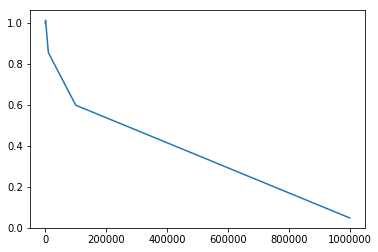

In [94]:
# Usando número e imágenes 10^6 y variando la camtidad de nodos
images = 100000
efficiency = [calculate_efficiency(nodes, images) for nodes in nodes_amount]

plt.plot(nodes_amount, efficiency)

## Punto 2 - wallclock

Calcular el tiempo que toma transmitir las imágenes para la fase de reducción

Consideraciones
* dataset de $10^6$ imágenes
* cada imagen de tamaño $1Mb = 10^6bytes$
* $g = 10^3$
* Red Ethernet de $1Gb/seg = 10^9bits/seg$

Iniciamos calculando el tamaño del dataset completo en bits, esto es $10^6 * 10^6 * 8 = 8*10^{12}$.
la entrada a la fase de reducción está dada por  $m(g - 1)$ con $n$ tamaño del set de imágenes y $g$ número de grupos.
Procedemos entonces a reemplazar los valores con los datos dados

$8*10^{12}(10^3 - 1) bits$ es la cantidad total de datos que se desean transmitir a la fase de reducción.

Con una velocidad de $10^9bits/seg$ tenemos entonces que el tiempo tomado es 

$\dfrac{8*10^{12}(10^3-1) bits}{10^9bits/seg}$ >>> $\dfrac{8*10^{12}(10^3-1) seg}{10^9}$ >>> $7992000 seg = 92.5 days$

## Punto 3 - Join de dos tablas

Dada la relación L(url_origen, url_destino) para los caminos en la red de tipo (url_1, url_2, url_3) queremos hallar cuántas posibles rutas hay desde url_1 hasta url_3 que involucren sólo un nodo intermedio.

|From|To|
|---|---|
|url_1|url_2|
|url_1|url_3|
|url_2|url_3|
|url_2|url_4|

para lograr el objetivo anterior debemos realizar un JOIN de L con sigo mismo, esto es $L1(u1, u2)$ JOIN $L2(u2, u3)$, en la siguiente figura se puede apreciar el procedimiento del JOIN

![Map Reduce join](images/map_reduce_join.png)

Suponiendo que usamos un Hash Join y que la cantidad de tuplas de $L$ está dada por $Tl$ entonces tenemos qué

$L1$ >>> archivo $L$ de tamaño $Tl$  
$L2$ >>> archivo $L$ de tamaño $Tl$  

### Tarea de mapeo

**Entrada**
* $Tl + Tl = 2Tl$
* $Tl + Tl = 2Tl$

### Tarea de reducción

**Salida**
* $Tl + Tl = 2Tl$
* $(Tl * Tl) * P = Tl^2 * P$

### Costo total
* $Costo = 2Tl + 2Tl + Tl^2 * p$
* $Costo = 4Tl + Tl^2*P$
* $Costo = = Tl(4 + Tl*P)$

### Número de procesos de mapeo y reducción 

Consideraciones iniciales
* $1*10^9$ >>> número de páginas a analizar
* $10$ $links$ >>> cantidad de links por página
* $10^{10}$ >>> tamaño de $Tl$
* $4096$ $bytes$ >>> tamaño de cada página
* $400$ $tuplas$ >>> cantidad de tuplas por página
* $11$ $Gb$ >>> memoria disponible por nodo

$tuple-size = \dfrac{page-size}{tuples-per-pages}$  <br><br>
$tuple-size = \dfrac{4096}{400} = 10.24bytes$  <br><br>

Con base al tamaño de cada tupla procedemos a calcular el tamaño total de los datos transportados <br><br>
$Tl = 10.24bytes * 10^{10} = 1.024*10^{11}$ <br><br>

Teniendo en cuenta que cada nodo tiene capacidad de $11Gb$ disponibles para el proceso entonces <br><br>
$11Gb = 1.18*10^10bytes$ <br><br>

Por lo tanto en memoria caben  <br><br>
$\dfrac{1.18*10^10bytes}{10.24bytes} = 1.15*10^9 tuples$ <br><br>

Finalmente dividiendo la cantidad total de tuplas entre la capacidad de tuplas por nodo tenemos <br><br>
$\dfrac{10^{10}}{1.15*10^9} = 9$ <br><br>

Concluímos entonces que para procesar las $10^9$ $pages$ son necesarios $9$ $nodos$